In [87]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.io.wavfile import read as wav_read
from scipy.fftpack import fft

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import LabelKFold
from sklearn.feature_extraction.text import CountVectorizer

Подготовим функцию для валидации. В качестве основной метрики будем использовать усреднённую точность классификации по всем людям с подобранным порогом бинаризации (честнее подбирать порог не на тестовой выборке, однако в таком случае размер датасета стал бы ещё меньше), то есть для каждого человека для всех его кардиограмм считается вероятность наличия болезни, вероятности для каждого человека усредняются и только потом это значение для всех людей бинаризуется для оценки точности. Дополнительно выведем среднюю точность по сигналам и AUC. Используем 20 фолдов разбиения людей для обучения/предсказания. В качестве базового алгоритма используем случайный лес из 100 деревьев с энтропийным критерием построения вершин. 

In [88]:
def validate(data, labels, print_result=True):
    cv = LabelKFold(people, n_folds=20)
    pred = np.zeros(labels.shape)

    for itrain, itest in cv:
        clf = RandomForestClassifier(n_estimators=100, criterion='entropy', n_jobs=-1, random_state=1)
        clf.fit(data[itrain, :], labels[itrain])
        pred[itest] = clf.predict_proba(data[itest, :])[:, 1]

    if print_result:
        print 'auc:', roc_auc_score(labels, pred)
        print ''

    tmp = pd.DataFrame({'people': people, 'true': labels, 'pred': pred, 'pred_bin': 0+(pred>0.5)})
    tmp['q'] = tmp.true == tmp.pred_bin

    if print_result:
        print 'acc by signals with thr = 0.5:', tmp.q.mean()
        print 'acc by people with thr = 0.5:', tmp.groupby('people')['q'].mean().mean()
        print ''

    lsp = np.linspace(0, 1, 100)
    acc = [np.mean(np.abs((tmp.pred > thr) == tmp.true)) for thr in lsp]
    if print_result:
        print 'max acc by signals:', max(acc), '| thr:', lsp[np.argmax(acc)]
    
    acc = []
    for thr in lsp:
        tmp['q'] = tmp.true == (tmp.pred > thr)
        acc.append(tmp.groupby('people')['q'].mean().mean())
    if print_result:
        print 'max acc by people:', max(acc), '| thr:', lsp[np.argmax(acc)]
    else:
        return max(acc)

Считаем все данные. Исключим из выборки короткие сигналы (длина менее 20000), так как из коротких замеров сложно извлечь достаточно информации.

In [89]:
people = []
signals = []
labels = []

pwd = 'ibs_true/'
files = os.listdir(pwd)
for f in files:
    w = wav_read(pwd + f)[1]
    if len(w) < 20000:
        # filter some short signals
        continue
    people.append(int(f.split('_')[0]))
    signals.append(w)
    labels.append(1)
    
pwd = 'ibs_false/'
files = os.listdir(pwd)
for f in files:
    w = wav_read(pwd + f)[1]
    if len(w) < 20000:
        # filter some short signals
        continue
    people.append(int(f.split('_')[0]))
    signals.append(w)
    labels.append(0)
    
people = np.array(people)
signals = np.array(signals)
labels = np.array(labels)

## 1. Базовое решение

Датасет состоит из 3 частей:

- 500 усреднённых коэффициентов Фурье, посчитанных по непересекающимся окнам длины 1000 (столько окон, сколько возможно).
- 20 наибольших сигнулярных чисел матрицы из предыдущего пунта (в строках 500 коэффициентов Фурье, количество строк зависит от длины сигналов, поэтому именно 20).
- Элементарные статистики по сигналам вроде среднего значения, разброса, доли времени, когда сигнал больше или меньше некоторого порога. 10 штук.

Всего 530 признаков.

In [4]:
count_fft_value = 500
count_singular_value = 20
count_statistics = 10

data = np.empty((len(labels), count_fft_value + count_singular_value + count_statistics))

for i in range(len(signals)):
    
    # simple fft
    count = len(signals[i]) / (count_fft_value * 2)
    mat = np.array(signals[i][: 2 * count_fft_value * count]).reshape((count, 2 * count_fft_value))
    mat_fft = np.empty((count, count_fft_value))
    for j in range(count):
        mat_fft[j] = np.abs(fft(mat[j])[:count_fft_value])
    data[i, :count_fft_value] = mat_fft.mean(axis=0)

    _, s, _ = np.linalg.svd(mat)
    data[i, count_fft_value : count_fft_value + count_singular_value] = s[:count_singular_value]
    
    statistics = []
    statistics.append(np.mean(signals[i] > 0))
    statistics.append(np.mean(signals[i] > np.mean(signals[i])))
    statistics.append(np.mean(signals[i] > np.mean(signals[i]) + np.std(signals[i])))
    statistics.append(np.mean(signals[i] < np.mean(signals[i]) - np.std(signals[i])))
    statistics.append(np.mean(signals[i] > np.mean(signals[i]) + 2 * np.std(signals[i])))
    statistics.append(np.mean(signals[i] < np.mean(signals[i]) - 2 * np.std(signals[i])))
    statistics.append(np.mean(signals[i]))
    statistics.append(np.std(signals[i]))
    statistics.append(np.mean((signals[i] < np.mean(signals[i]) + np.std(signals[i])) & (signals[i] > np.mean(signals[i]) - np.std(signals[i]))))
    statistics.append(np.mean((signals[i] < np.mean(signals[i]) + 2 * np.std(signals[i])) & (signals[i] > np.mean(signals[i]) - 2 * np.std(signals[i]))))
    
    data[i, count_fft_value + count_singular_value :] = np.array(statistics)

In [8]:
validate(data, labels)

auc: 0.759389201272

acc by signals with thr = 0.5: 0.785596299967
acc by people with thr = 0.5: 0.687313281238

max acc by signals: 0.792864222002 | thr: 0.656565656566
max acc by people: 0.75197378075 | thr: 0.323232323232


То есть максимально полученная усреднённая точность: 75.2%.

In [9]:
data_fft_simple = data[:, :500]
data_singular_simple = data[:, 500:520]

Только на коэффициентах Фурье:

In [10]:
validate(data_fft_simple, labels)

auc: 0.747036243065

acc by signals with thr = 0.5: 0.780640898579
acc by people with thr = 0.5: 0.693222638521

max acc by signals: 0.787578460522 | thr: 0.636363636364
max acc by people: 0.729167782082 | thr: 0.333333333333


## 2. Признаки Успенского

Реализуем функцию для поиска пиков на кардиограмме. Используем следующую эвритику: пик – это точка, значение в которой не менее 0.7 от максимума в окрестности 700 исследуемого окна, при этом слева и справа от пика есть хотя бы одно отрицательное значение. Использовалось окно длиной 300, шаг 150. То есть:

- Выделяется очередное окно длиной 300.
- Вычисляется максимальноее значение сигнала в окрестности 700 окна (длиной 1700=300+700+700).
- В окне находится максимальное значение сигнала.
- Если это значение более 0.7 от найденного ранее максимума, слева и справа от окна есть отрицательные значения, то точка считается пиком.

Всего 252 признака.

In [90]:
def find_maximums(signal, window, step):
    left = 0
    right = window
    inds = []
    
    while right <= len(signal):
        f = False
        part = signal[left:right]
        threshold = np.max(signal[max(0, left - 700):min(len(signal), right + 700)]) * 0.7
        if any(part > threshold):
            max_ind = np.argmax(part)
            if any(part[:max_ind] < 0) and any(part[max_ind:] < 0):
                if not inds or inds[-1] != max_ind + left:
                    f = True
                    inds.append(max_ind + left)
                    left += window
                    right += window
        if not f:
            left += step
            right += step
    return np.array(inds)

Пример выделения пиков на кардиограмме:

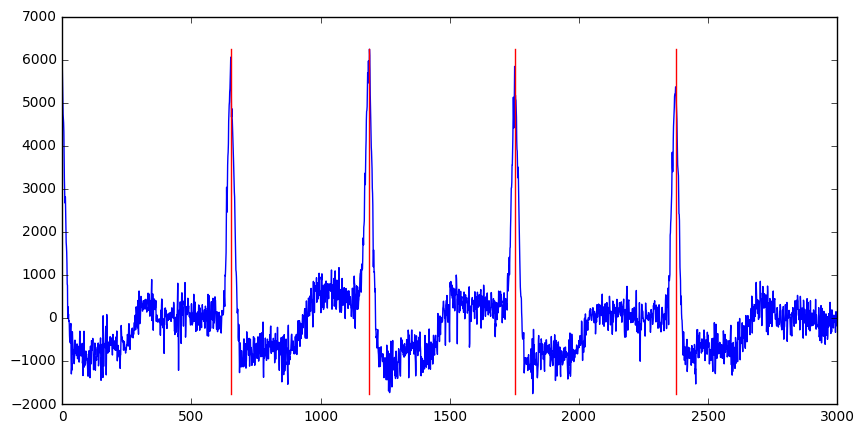

In [91]:
right = 3000
inds = find_maximums(signals[0], window=300, step=150)
inds = [i for i in inds if i < right]
plt.figure(figsize=(10, 5))
plt.plot(signals[0][:right])
for i in inds:
    plt.plot([i, i], [min(signals[0][:right]), max(signals[0][:right])], 'r')
plt.show()

Естественно, на шумовых кардиограммах получается некорректный результат.

Зная местоположения пиков кардиграмм, вычислим признаки Успенского (вычисляются изменения расстояний между пиками, изменений высоты пиков и угла наклона между пиками, эти три величины кодируются одним словом и для каждого человека считается количество каждого из 6 возможных слов, подробнее: http://www.machinelearning.ru/wiki/images/6/62/Voron-2014-task-ekg-about.pdf). 

In [92]:
def make_features(signal, inds, window):
    R = []
    T = inds[1:] - inds[:-1]
    alpha = []
    
    for i, x in enumerate(inds[:-1]):
        left = max(0, x - window / 2)
        right = min(len(signal), x + window / 2)
        min_value = np.min(signal[left:right])
        max_value = signal[x]
        R.append(float(max_value) - float(min_value))
        alpha.append(np.arctan(float(R[-1]) / float(T[i])))
        
    R = np.array(R)
    alpha = np.array(alpha)
    
    dR = ((np.sign(R[1:] - R[:-1]) + 1) / 2).astype(int)
    dT = ((np.sign(T[1:] - T[:-1]) + 1) / 2).astype(int)
    dalpha = ((np.sign(alpha[1:] - alpha[:-1]) + 1) / 2).astype(int)
    
    words = []
    for i in range(len(dR)):
        words.append(str(dR[i]) + str(dT[i]) + str(dalpha[i]))

    return words

In [93]:
window = 300
step = 150

corpus = []

for signal in signals:
    inds = find_maximums(signal=signal, window=window, step=step)
    words = make_features(signal=signal, inds=inds, window=window)
    corpus.append(words)

Кроме 3-грамм возьмём и 2-граммы.

In [94]:
corpus_s = [' '.join(x) for x in corpus]
vectorizer = CountVectorizer(ngram_range=(2, 3))
data = vectorizer.fit_transform(corpus_s).todense().astype(float)

In [95]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [96]:
validate(data, labels)

auc: 0.684496055763

acc by signals with thr = 0.5: 0.767756854972
acc by people with thr = 0.5: 0.62652906147

max acc by signals: 0.780640898579 | thr: 0.636363636364
max acc by people: 0.774790132164 | thr: 0.232323232323


То есть максимальная точность, усреднённая по людям составила 77.5%

In [97]:
data_uspenskii = data

## 3. Статистики по пикам

Построим признаки по базовым статистикам, которые можно извлечь, зная местоположения пиков.

Средние значения, среднеквадратичные отклонения, минимумы, максимумы высот пиков, расстояний между пиками, углов и их всевозможных отношений.

Всего 24 признака.

In [19]:
window = 300
step = 150

data = []
for signal in signals:
    features = []
    inds = find_maximums(signal=signal, window=window, step=step)
    
    R = []
    T = np.array(inds[1:] - inds[:-1], dtype=float)
    alpha = []
    
    for i, x in enumerate(inds[:-1]):
        left = max(0, x - window / 2)
        right = min(len(signal), x + window / 2)
        min_value = np.min(signal[left:right])
        max_value = signal[x]
        R.append(float(max_value) - float(min_value))
        alpha.append(np.arctan(float(R[-1]) / float(T[i])))
        
    R = np.array(R)
    alpha = np.array(alpha)
    
    features.append(np.mean(T))
    features.append(np.mean(R))
    features.append(np.mean(alpha))

    features.append(np.std(T))
    features.append(np.std(R))
    features.append(np.std(alpha))
    
    features.append(np.min(T))
    features.append(np.min(R))
    features.append(np.min(alpha))
    
    features.append(np.max(T))
    features.append(np.max(R))
    features.append(np.max(alpha))

    features.append(np.mean(R / alpha))
    features.append(np.mean(T / alpha))
    features.append(np.mean(R / T))
    
    features.append(np.std(R / alpha))
    features.append(np.std(T / alpha))
    features.append(np.std(R / T))
    
    features.append(np.min(R / alpha))
    features.append(np.min(T / alpha))
    features.append(np.min(R / T))
    
    features.append(np.max(R / alpha))
    features.append(np.max(T / alpha))
    features.append(np.max(R / T))

    data.append(features)
    
data = np.array(data)

In [20]:
validate(data, labels)

auc: 0.681667111014

acc by signals with thr = 0.5: 0.753221010902
acc by people with thr = 0.5: 0.618573851302

max acc by signals: 0.767096134787 | thr: 0.69696969697
max acc by people: 0.676710498541 | thr: 0.353535353535


То есть максимальное усреднённое качество 67.7%.

In [21]:
data_interval_stats = data

## 4. Статистики QRS-комплекса

Построим датасет с попыткой имитировать ручной анализ QRS-комлекса. Вычислим признаки на статистикам интервалов: 

- Средние значения и среднеквадратичные отклонения максимумов, минимумов, средних значений, среднеквадратичных отклонений в окне сигнала вокруг пика.
- Средние значения и среднеквадратичные отклонения длин QRS, значений ST, доли ST>0, значений Q, S, их отношений.

Всего 30 признаков.

In [22]:
data = []
for signal in signals:
    features = []
    inds = find_maximums(signal=signal, window=300, step=150)
    inds = [x for x in inds if x >= 500 and x < len(signal) - 500]
    
    max_ = []
    mean_ = []
    min_ = []
    std_ = []
    
    st_ = []
    st_frac_ = []
    q_ = []
    s_ = []
    qrs_ = []
    
    for ind in inds:
        part = signal[ind-500:ind+500]
        max_.append(np.max(part))
        mean_.append(np.mean(part))
        min_.append(np.min(part))
        std_.append(np.std(part))
        
        s_arg = np.argmin(part[500:700])
        t_arg = np.argmax(part[500+s_arg:])
        s_.append(part[500+s_arg])
        st_.append(np.mean(part[500+s_arg:500+s_arg+t_arg+1]))
        st_frac_.append(np.mean(part[500+s_arg:500+s_arg+t_arg+1] < 0))

        q_arg = np.argmin(part[300:500])
        q_.append(part[300+q_arg])
        qrs_.append((s_arg+500) - (q_arg+300))
    
    max_ = np.array(max_) + 1e-10
    mean_ = np.array(mean_) + 1e-10
    min_ = np.array(min_) + 1e-10
    std_ = np.array(std_)
    
    st_ = np.array(st_)
    st_frac_ = np.array(st_frac_)
    q_ = np.array(q_)
    s_ = np.array(s_)
    qrs_ = np.array(qrs_)
                        
    features.append(np.mean(max_))
    features.append(np.mean(min_))
    features.append(np.mean(mean_))
    features.append(np.mean(std_))
                        
    features.append(np.std(max_))
    features.append(np.std(min_))
    features.append(np.std(mean_))
    features.append(np.std(std_))
                        
    features.append(np.mean(max_ / min_))
    features.append(np.std(max_ / min_))                    
                        
    features.append(np.mean(st_))
    features.append(np.mean(st_frac_))
    features.append(np.mean(st_ / mean_))
    features.append(np.std(st_))
    features.append(np.std(st_frac_))
    features.append(np.std(st_ / mean_))
                        
    features.append(np.mean(s_))
    features.append(np.std(s_))
                        
    features.append(np.mean(q_))
    features.append(np.std(q_))
                        
    features.append(np.mean(qrs_))
    features.append(np.std(qrs_))
                        
    features.append(np.mean(s_ / max_))
    features.append(np.mean(q_ / max_))
                        
    features.append(np.mean(max_ - s_))
    features.append(np.std(max_ - s_))
                        
    features.append(np.mean(max_ - q_))
    features.append(np.std(max_ - q_))
        
    features.append(np.mean(q_ / (s_ + 1e-10)))
    features.append(np.std(q_ / (s_ + 1e-10)))
                        
    data.append(features)
    
data = np.array(data)

In [23]:
validate(data, labels)

auc: 0.72682527255

acc by signals with thr = 0.5: 0.767096134787
acc by people with thr = 0.5: 0.682082585322

max acc by signals: 0.782292699042 | thr: 0.666666666667
max acc by people: 0.706963505511 | thr: 0.373737373737


То есть максимальное качество составило 70.7%.

In [25]:
data_stats_interval = data

## 5. Фурье-признаки, сингулярные числа и статистики по интервалам с пиками

(Аналог пункта 1, но вместе подряд идущих непересекающихся окон берутся окна длиной тысячу вокруг каждого пика).

Всего 530 признаков.

In [41]:
count_fft_value = 500
count_singular_value = 20
count_statistics = 10

data = np.empty((len(labels), count_fft_value + count_singular_value + count_statistics))

for i in range(len(signals)):
 
    # fft by intervals
    inds = find_maximums(signals[i], 300, 150)
    inds = [x for x in inds if x >= count_fft_value and x < len(signals[i]) - count_fft_value]
    count = len(inds)
    mat = np.empty((count, 2 * count_fft_value))
    mat_fft = np.empty((count, count_fft_value))
    for j in range(count):
        mat[j] = signals[i][inds[j] - count_fft_value : inds[j] + count_fft_value]
        mat_fft[j] = np.abs(fft(mat[j])[:count_fft_value])
    data[i, :count_fft_value] = mat_fft.mean(axis=0)

    _, s, _ = np.linalg.svd(mat)
    data[i, count_fft_value : count_fft_value + count_singular_value] = s[:count_singular_value]
    
    statistics = []
    statistics.append(np.mean(signals[i] > 0))
    statistics.append(np.mean(signals[i] > np.mean(signals[i])))
    statistics.append(np.mean(signals[i] > np.mean(signals[i]) + np.std(signals[i])))
    statistics.append(np.mean(signals[i] < np.mean(signals[i]) - np.std(signals[i])))
    statistics.append(np.mean(signals[i] > np.mean(signals[i]) + 2 * np.std(signals[i])))
    statistics.append(np.mean(signals[i] < np.mean(signals[i]) - 2 * np.std(signals[i])))
    statistics.append(np.mean(signals[i]))
    statistics.append(np.std(signals[i]))
    statistics.append(np.mean((signals[i] < np.mean(signals[i]) + np.std(signals[i])) & (signals[i] > np.mean(signals[i]) - np.std(signals[i]))))
    statistics.append(np.mean((signals[i] < np.mean(signals[i]) + 2 * np.std(signals[i])) & (signals[i] > np.mean(signals[i]) - 2 * np.std(signals[i]))))
    
    data[i, count_fft_value + count_singular_value :] = np.array(statistics)

In [27]:
validate(data, labels)

auc: 0.76396075186

acc by signals with thr = 0.5: 0.779319458209
acc by people with thr = 0.5: 0.680093414886

max acc by signals: 0.792864222002 | thr: 0.585858585859
max acc by people: 0.728513476882 | thr: 0.353535353535


То есть максимальное качество 72.9%.

In [42]:
data_fft_interval = data[:, :500]
data_singular_interval = data[:, 500:520]
data_simple_stats = data[:, 520:]

In [29]:
validate(data_fft_interval, labels)

auc: 0.755854226709

acc by signals with thr = 0.5: 0.783614139412
acc by people with thr = 0.5: 0.674786033077

max acc by signals: 0.797489263297 | thr: 0.646464646465
max acc by people: 0.738896574402 | thr: 0.272727272727


Если использовать только коэффциенты Фурье, то качество получается выше, чем аналогичное для коэффициентов Фурье для непересекающихся подряд идущих окон.

Итого получаем по датасетам:

| Признаки        | Качество      |
| -------------   | ------------- |
| Фурье, сингул.числа, статистики | 75.2% |
| Признаки Успенского             | 77.5% |  
| Статистики по интервалам        | 67.7% |
| Статистики по QRS               | 70.7% |
| Фурье, сингул.числа, статистики по интервалам   | 72.9% |
| Фурье по обычным окнам          | 72.9% |
| Фурье по окнам с пиками         | 73.9% |

Естественно, на каждом из датасетов можно получить более высокое качество, если убрать некоторые "плохие" признаки и аккуратно настроить алгоритм.

Объединять все признаки вместе плохая идея, так как признаков станет слишком много. Поэтому реализуем простую функцию для уменьшения количества признаков в каждом датасете с учётом их важности в построенном лесе. 

In [98]:
def reduce_dataset(data, labels, every=1):
    clf = RandomForestClassifier(n_estimators=100, criterion='entropy', n_jobs=-1, random_state=1)
    clf.fit(data, labels)

    thresholds = np.sort(clf.feature_importances_)
    best_acc = 0

    for thr in [0] + list(thresholds[::every]):
        if not sum(clf.feature_importances_ > thr):
            continue
        acc = validate(data[:, clf.feature_importances_ > thr], labels, print_result=False)
        if acc > best_acc:
            best_acc = acc
            best_thr = thr
    
    print 'best accuracy:', best_acc
    print 'best threshold:', best_thr
    print 'before shape:', data.shape
    print 'after shape:', data[:, clf.feature_importances_ > best_thr].shape
    
    return data[:, clf.feature_importances_ > best_thr]

Запустим на всех наборах с разным шагом перебора (для уменьшения времени вычисления).

In [6]:
data_fft_interval = reduce_dataset(data_fft_interval, labels, every=10)

best accuracy: 0.766208916718
best threshold: 0.00641863882646
before shape: (3027, 500)
after shape: (3027, 29)


In [6]:
data_fft_simple = reduce_dataset(data_fft_simple, labels, every=10)

best accuracy: 0.767436252733
best threshold: 0.00371588570901
before shape: (3027, 500)
after shape: (3027, 59)


In [10]:
data_interval_stats = reduce_dataset(data_interval_stats, labels, every=2)

best accuracy: 0.674142977703
best threshold: 0.039100102802
before shape: (3027, 24)
after shape: (3027, 15)


In [15]:
data_simple_stats = reduce_dataset(data_simple_stats, labels, every=1)

best accuracy: 0.703690706159
best threshold: 0.0766654574105
before shape: (3027, 10)
after shape: (3027, 9)


In [25]:
data_singular_interval = reduce_dataset(data_singular_interval, labels, every=2)

best accuracy: 0.636201121764
best threshold: 0.0503770095615
before shape: (3027, 20)
after shape: (3027, 7)


In [28]:
data_singular_simple = reduce_dataset(data_singular_simple, labels, every=2)

best accuracy: 0.62783879947
best threshold: 0.104581827919
before shape: (3027, 9)
after shape: (3027, 6)


In [31]:
data_stats_interval = reduce_dataset(data_stats_interval, labels, every=2)

best accuracy: 0.715851080157
best threshold: 0.0257278053912
before shape: (3027, 30)
after shape: (3027, 23)


In [99]:
data_uspenskii = reduce_dataset(data_uspenskii, labels, every=5)

best accuracy: 0.776124211842
best threshold: 0.0024697951121
before shape: (3027, 252)
after shape: (3027, 146)


In [101]:
data = np.hstack((data_fft_interval, data_fft_simple, data_interval_stats, data_simple_stats, 
                  data_singular_interval, data_singular_simple, data_stats_interval, data_uspenskii))
data.shape

(3027, 294)

То есть получили 294 признаки (меньше, чем в признаках с одними только коэффициентами Фурье).

In [102]:
validate(data, labels)

auc: 0.824447390675

acc by signals with thr = 0.5: 0.822596630327
acc by people with thr = 0.5: 0.745121719608

max acc by signals: 0.823587710605 | thr: 0.545454545455
max acc by people: 0.798482691679 | thr: 0.353535353535


Получаем 79.8% качества.

Если сделать такую фильтрацию для него:

In [103]:
data_reduced = reduce_dataset(data, labels, every=5)

best accuracy: 0.805831625636
best threshold: 0.00290834881605
before shape: (3027, 294)
after shape: (3027, 143)


In [104]:
validate(data_reduced, labels)

auc: 0.834978424018

acc by signals with thr = 0.5: 0.83217707301
acc by people with thr = 0.5: 0.747032677778

max acc by signals: 0.834489593657 | thr: 0.545454545455
max acc by people: 0.805831625636 | thr: 0.363636363636


Получаем 80.6% точности.

Естественно, такой отбор признаков довольно плохой, однако даже с ним можно добиться более высокого качества (с некоторым переобучением, так как использовался один и тот же алгоритм). Кроме того, результат может быть довольно нестабильным. 